In [67]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np

## Global parameters

In [68]:

S0 = 80.0          # Initial stock price
r = 0.055          # Risk-free rate (5.5%)
sigma = 0.35       # Volatility (for Merton / BS part)
T = 1.0 / 4.0      # 3 months
K_ATM = 80.0       # ATM strike

I = 100000         # Number of simulations (paths)
M = 2000          # Time steps
dt = T / M


## Henston model

In [69]:
# Random number generator
def random_number_gen(M, I):
    # 2 correlated shocks for each time step and simulation
    return np.random.standard_normal((2, M+1, I))

# CIR volatility process
def SDE_vol(v0, kappa, theta, sigma, T, M, I, rand, cho_matrix):
    dt = T / M
    sdt = np.sqrt(dt)

    v = np.zeros((M+1, I))
    v[0] = v0

    for t in range(1, M+1):
        # Apply Cholesky to get correlated shocks for each simulation
        ran = cho_matrix @ rand[:, t, :]   # shape: (2, I)
        dW = ran[1] * sdt                  # volatility uses the 2nd BM

        v[t] = np.maximum(
            0,
            v[t-1] + kappa * (theta - v[t-1]) * dt +
            sigma * np.sqrt(v[t-1]) * dW
        )

    return v

#  Heston price process
def Heston_paths(S0, r, V, T, M, I, rand, cho_matrix):
    dt = T / M
    sdt = np.sqrt(dt)

    S = np.zeros((M+1, I))
    S[0] = S0

    for t in range(1, M+1):
        ran = cho_matrix @ rand[:, t, :]   # shape: (2, I)
        dW = ran[0] * sdt                  # price uses the 1st BM

        S[t] = S[t-1] * np.exp(
            (r - 0.5 * V[t-1]) * dt +
            np.sqrt(V[t-1]) * dW
        )
    return S


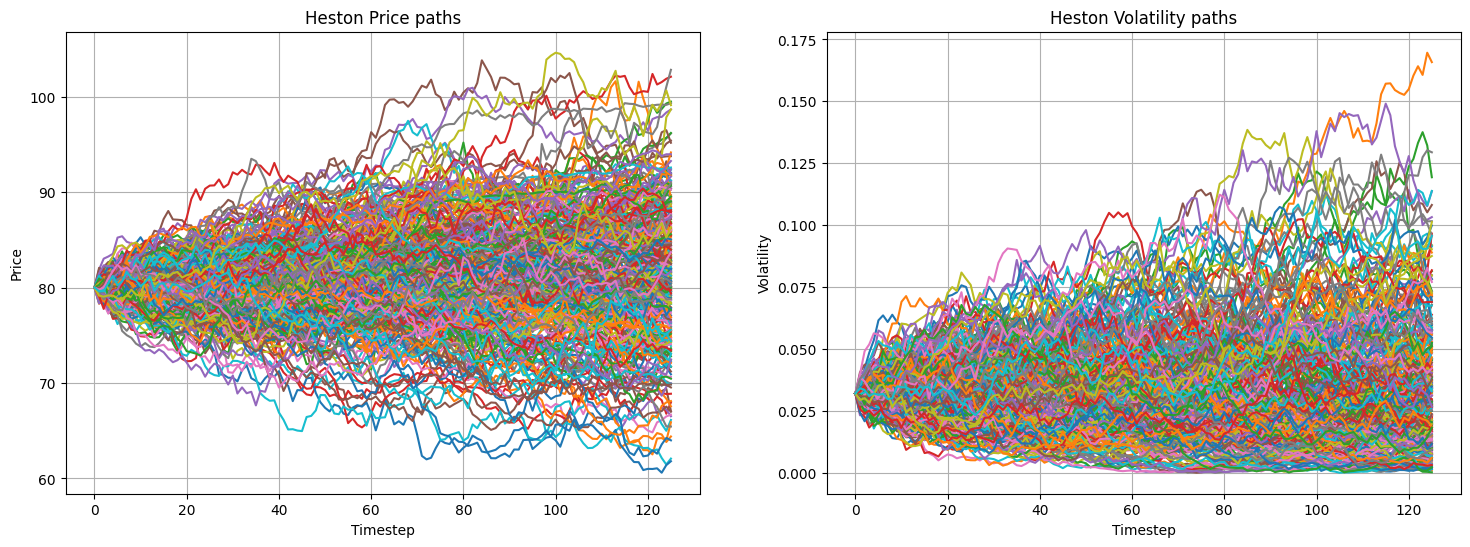

In [70]:

# PARAMETERS
v0 = 0.032
kappa_v = 1.85
sigma_v = 0.35
theta_v = 0.045
rho = -0.3
S0 = 80
K = 80
r = 0.055
M0 = 500
T = 0.25
M = int(M0 * T)
I = 100000
dt = T / M

# Random numbers
rand = random_number_gen(M, I)

# Correlation matrix
cov_matrix = np.array([[1, rho],
                       [rho, 1]])
cho_matrix = np.linalg.cholesky(cov_matrix)

# Simulate volatility and price
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, cho_matrix)
S = Heston_paths(S0, r, V, T, M, I, rand, cho_matrix)

# Plotting function
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")

plot_paths(300)


In [71]:
def heston_price_call_put(
    S0, K, r, T,
    v0, kappa_v, theta_v, sigma_v,
    rho, M, I
):
    """
    Simulate Heston paths for a given rho and price
    a European call and put using shared paths.
    """
    # 1) Random numbers
    rand = random_number_gen(M, I)

    # 2) Correlation matrix and Cholesky
    cov_matrix = np.array([[1.0, rho],
                           [rho, 1.0]])
    cho_matrix = np.linalg.cholesky(cov_matrix)

    # 3) Volatility and price paths
    V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, cho_matrix)
    S = Heston_paths(S0, r, V, T, M, I, rand, cho_matrix)

    # 4) Price call & put using the same S
    call_price = heston_call_mc(S, K, r, T, 0.0)
    put_price  = heston_put_mc(S, K, r, T, 0.0)

    return call_price, put_price, S, V


## Q5
#### pricing an ATM European call and an ATM European put, using a correlation value of -0.30.

In [76]:
def heston_call_mc(S, K, r, T, t):
 payoff = np.maximum(0, S[-1, :] - K)
 average = np.mean(payoff)
 return np.exp(-r * (T - t)) * average

call_q5 = heston_call_mc(S, K, r, T, 0)
print("\n=== Q5: Heston (rho = -0.30) with Collins-style engine ===")
print(f"European Call Price under Heston: {call_q5:.2f}")

def heston_put_mc(S, K, r, T, t):
    payoff = np.maximum(0, K - S[-1, :])
    average = np.mean(payoff)
    return np.exp(-r * (T - t)) * average

put_q5  = heston_put_mc(S, K, r, T, 0)
print(f"European Put Price under Heston: {put_q5:.2f}")


=== Q5: Heston (rho = -0.30) with Collins-style engine ===
European Call Price under Heston: 3.47
European Put Price under Heston: 2.37


## Q6

#### pricing an ATM European call and an ATM European put, using a correlation value of -0.70.

In [75]:
rho_q6 = -0.7

# Rebuild correlation matrix and Cholesky with new rho
cov_matrix_q6 = np.array([[1, rho_q6],
                          [rho_q6, 1]])
cho_matrix_q6 = np.linalg.cholesky(cov_matrix_q6)

# New random numbers for Q6 (or reuse 'rand' if desired)
rand_q6 = random_number_gen(M, I)

# Simulate volatility and price paths under rho = -0.70
V_q6 = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand_q6, cho_matrix_q6)
S_q6 = Heston_paths(S0, r, V_q6, T, M, I, rand_q6, cho_matrix_q6)

call_q6 = heston_call_mc(S_q6, K, r, T, 0)
put_q6  = heston_put_mc(S_q6, K, r, T, 0)

# --- Print results exactly as before ---
print("\n=== Q6: Heston (rho = -0.70) with Collins-style engine ===")
print(f"European Call Price under Heston: {call_q6:.4f}")
print(f"European Put  Price under Heston: {put_q6:.4f}")



=== Q6: Heston (rho = -0.70) with Collins-style engine ===
European Call Price under Heston: 3.5052
European Put  Price under Heston: 2.4045


## Q7
#### Calculating delta and gamma for each of the options

In [11]:
#Q7
import numpy as np

S0,K,r,T = 80.0,80.0,0.055,3/12
v0,kappa,theta,sigv = 0.032,1.85,0.045,0.35
n_steps,n_paths = 120,10000
dt,sd = T/n_steps, (T/n_steps)**0.5

def ST_paths(S0,r,T,v0,kappa,theta,sigv,rho,z1,z2):
    def evolve(zn1,zn2):
        S=np.full(z1.shape[1],S0); v=np.full(z1.shape[1],v0)
        for t in range(z1.shape[0]):
            w2=rho*zn1[t]+np.sqrt(1-rho*rho)*zn2[t]
            vpos=np.maximum(v,0.0)
            v=v+kappa*(theta-vpos)*dt+sigv*np.sqrt(vpos)*sd*w2
            v=np.maximum(v,0.0)
            S=S*np.exp((r-0.5*vpos)*dt+np.sqrt(vpos)*sd*zn1[t])
        return S
    ST1=evolve(z1,z2); ST2=evolve(-z1,-z2)
    return np.concatenate([ST1,ST2])

def price(ST):
    disc=np.exp(-r*T)
    return (disc*np.maximum(ST-K,0)).mean(), (disc*np.maximum(K-ST,0)).mean()

def greeks(S0,rho,h_rel=0.01,seed=123):
    h=h_rel*S0; rng=np.random.default_rng(seed)
    z1=rng.standard_normal((n_steps,n_paths))
    z2=rng.standard_normal((n_steps,n_paths))
    ST = ST_paths(S0, r,T,v0,kappa,theta,sigv,rho,z1,z2)
    STu = ST_paths(S0+h, r,T,v0,kappa,theta,sigv,rho,z1,z2)
    STd = ST_paths(S0-h, r,T,v0,kappa,theta,sigv,rho,z1,z2)
    C,P = price(ST); Cu,Pu = price(STu); Cd,Pd = price(STd)
    dC=(Cu-Cd)/(2*h); gC=(Cu-2*C+Cd)/h**2
    dP=(Pu-Pd)/(2*h); gP=(Pu-2*P+Pd)/h**2
    return C,P,dC,gC,dP,gP

    # Örnek:
print(greeks(S0, rho=-0.30))
print(greeks(S0, rho=-0.70))

(np.float64(3.4848303319764353), np.float64(2.3840303155608455), np.float64(0.6036828447145909), np.float64(0.05528383999305746), np.float64(-0.3964212549576443), np.float64(0.05528383999305676))
(np.float64(3.504928650499789), np.float64(2.4107235255080357), np.float64(0.6329403230408056), np.float64(0.050993852044069886), np.float64(-0.3670813404886314), np.float64(0.05099385204406503))


In [12]:


def simulate_paths(S0, r, T, v0, kappa, theta, sigma_v, rho,
                   n_steps, n_paths, z1, z2):
    """
    Full-truncation Euler Heston paths using supplied normal draws z1 (asset) and z2 (variance).
    S: (n_steps+1, n_paths), V: (n_steps+1, n_paths)
    """
    dt = T / n_steps
    sdt = np.sqrt(dt)
    S = np.full((n_steps + 1, n_paths), S0, dtype=np.float64)
    V = np.full((n_steps + 1, n_paths), v0, dtype=np.float64)

    for t in range(1, n_steps + 1):
        # Correlated variance shock
        w2 = rho * z1[t - 1] + np.sqrt(1.0 - rho**2) * z2[t - 1]
        vpos = np.maximum(V[t - 1], 0.0)
        # Variance step (full truncation)
        V[t] = V[t - 1] + kappa * (theta - vpos) * dt + sigma_v * np.sqrt(vpos) * sdt * w2
        V[t] = np.maximum(V[t], 0.0)
        # Asset step (log-Euler)
        S[t] = S[t - 1] * np.exp((r - 0.5 * vpos) * dt + np.sqrt(vpos) * sdt * z1[t - 1])

    return S, V

def american_call_lsm_from_normals(S0, K, r, T, v0, kappa, theta, sigma_v, rho,
                                   n_steps, n_paths, z1, z2, basis="poly2_sv"):
    """
    American CALL via Longstaff–Schwartz using supplied normal draws.
    basis="poly2_s" -> [1, S, S^2]
    basis="poly2_sv"-> [1, S, S^2, v, v*S]
    Returns the price (float) at t=0.
    """
    dt = T / n_steps
    disc = np.exp(-r * dt)

    S, V = simulate_paths(S0, r, T, v0, kappa, theta, sigma_v, rho,
                          n_steps, n_paths, z1, z2)
    payoff = np.maximum(S - K, 0.0)          # call payoff
    CF = payoff[-1].copy()                   # cashflow at maturity

    # Backward induction
    for t in range(n_steps - 1, 0, -1):
        CF *= disc                            # discount one step
        itm = payoff[t] > 0                   # in-the-money mask
        if np.any(itm):
            X = S[t, itm]
            if basis == "poly2_s":
                A = np.stack([np.ones_like(X), X, X * X], axis=1)
            else:
                vv = V[t, itm]
                A = np.stack([np.ones_like(X), X, X * X, vv, vv * X], axis=1)
            Y = CF[itm]
            beta, *_ = np.linalg.lstsq(A, Y, rcond=None)
            cont = A @ beta
            exercise = payoff[t, itm] > cont
            CF[itm] = np.where(exercise, payoff[t, itm], Y)

    return float(CF.mean())

# Parameters (rho = -0.70)
S0, K, r, T = 80.0, 80.0, 0.055, 3/12
v0, kappa, theta, sigma_v, rho = 0.032, 1.85, 0.045, 0.35, -0.70
n_steps, n_paths, h_rel, seed = 120, 10_000, 0.01, 2030
h = h_rel * S0
C0 = 3.458  # base American call price already computed

# Common Random Numbers
rng = np.random.default_rng(seed)
z1 = rng.standard_normal((n_steps, n_paths))
z2 = rng.standard_normal((n_steps, n_paths))

# Bump-and-reprice (use SAME z1, z2 for S0+h and S0-h)
Cu = american_call_lsm_from_normals(S0 + h, K, r, T, v0, kappa, theta, sigma_v, rho,
                                    n_steps, n_paths, z1, z2)
Cd = american_call_lsm_from_normals(S0 - h, K, r, T, v0, kappa, theta, sigma_v, rho,
                                    n_steps, n_paths, z1, z2)

delta = (Cu - Cd) / (2.0 * h)
gamma = (Cu - 2.0 * C0 + Cd) / (h * h)

print(f"delta is : {delta:.3f}")
print(f"gamma is : {gamma:.3f}")

delta is : 0.631
gamma is : 0.131


## Merton Model

In [54]:

class Merton_Model:
    def simulate_stock_paths(self, S0, T, r, sigma, lamb, mu, delta, I, M):
        dt = T/M
        SM = np.zeros((M+1, I))
        SM[0] = S0


        rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)


        z1 = np.random.standard_normal((M+1, I))
        z2 = np.random.standard_normal((M+1, I))


        y = np.random.poisson(lamb * dt, (M+1, I))

        for t in range(1, M+1):
            SM[t] = SM[t - 1] * (np.exp((r-rj-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z1[t])
                                 + (np.exp(mu + delta*z2[t]) - 1)*y[t])

            SM[t] = np.maximum(SM[t], 0.00001)
        return SM

    def price_option_merton76(self, S0, K, T, r, sigma, lamb, mu, delta, I, M, option_type='call'):

        # Simulate stock paths
        SM = self.simulate_stock_paths(S0, T, r, sigma, lamb, mu, delta, I, M)
        ST = SM[-1]

        # Calculate payoffs
        if option_type == 'call':
            payoffs = np.maximum(ST - K, 0)
        elif option_type == 'put':
            payoffs = np.maximum(K - ST, 0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        option_price = np.exp(-r * T) * np.mean(payoffs)
        return option_price

    def plot_stock_paths(self, SM):
        plt.figure(figsize=(12, 6))
        plt.plot(SM[:, :50])  # Plot first 50 paths for clarity
        plt.title("Merton '76 Stock Price Paths")
        plt.xlabel("Time Step")
        plt.ylabel("Stock Price")
        plt.show()

    def calculate_return_distribution(self, SM, S0):
        # Calculate log returns
        retSM = np.log(SM[-1, :] / S0)
        return retSM

    def plot_return_distribution(self, retSM):
        x = np.linspace(retSM.min(), retSM.max(), 500)

        plt.figure(figsize=(12, 6))
        plt.hist(retSM, density=True, bins=500, alpha=0.6, color='g')
        plt.plot(x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color='r', label='Normal density')
        plt.title("Return Distribution vs Normal Distribution")
        plt.xlabel("Log Return")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    def calc_greeks(self, S0, K, T, r, sigma, lamb, mu, delta, I, M, option_type='call', h=0.01):
         # Reproducible seed for the CRN
        seed = 12345

        # Simulating the Base price
        np.random.seed(seed)
        SM_base = self.simulate_stock_paths(S0, T, r, sigma, lamb, mu, delta, I, M)
        ST_base = SM_base[-1]
        disc = np.exp(-r * T)
        if option_type == 'call':
            pay_base = disc * np.maximum(ST_base - K, 0.0)
        else:
            pay_base = disc * np.maximum(K - ST_base, 0.0)

        # Up simulation 
        np.random.seed(seed)
        SM_up = self.simulate_stock_paths(S0 + h, T, r, sigma, lamb, mu, delta, I, M)
        ST_up = SM_up[-1]
        if option_type == 'call':
            pay_up = disc * np.maximum(ST_up - K, 0.0)
        else:
            pay_up = disc * np.maximum(K - ST_up, 0.0)

        # Down simulation
        np.random.seed(seed)
        SM_down = self.simulate_stock_paths(S0 - h, T, r, sigma, lamb, mu, delta, I, M)
        ST_down = SM_down[-1]
        if option_type == 'call':
            pay_down = disc * np.maximum(ST_down - K, 0.0)
        else:
            pay_down = disc * np.maximum(K - ST_down, 0.0)

        # Pathwise finite-difference estimators
        delta_path = (pay_up - pay_down) / (2.0 * h)
        gamma_path = (pay_up - 2.0 * pay_base + pay_down) / (h ** 2)

        # Averages (Monte Carlo estimators)
        delta = float(np.mean(delta_path))
        gamma = float(np.mean(gamma_path))

        return {'Delta': delta, 'Gamma': gamma}

    def price_call_put_merton76(self, S0, K, T, r, sigma, lamb, mu, delta, I, M):
        
        SM = self.simulate_stock_paths(S0, T, r, sigma, lamb, mu, delta, I, M)
        ST = SM[-1]

        disc = np.exp(-r * T)
        call = disc * np.mean(np.maximum(ST - K, 0))
        put  = disc * np.mean(np.maximum(K - ST, 0))
        return call, put


# Single shared object for all Q8–Q10
merton_model = Merton_Model()


## Q 8
Using the Merton Model, price an ATM European call and an ATM European put with jump intensity parameter equal to 0.75.

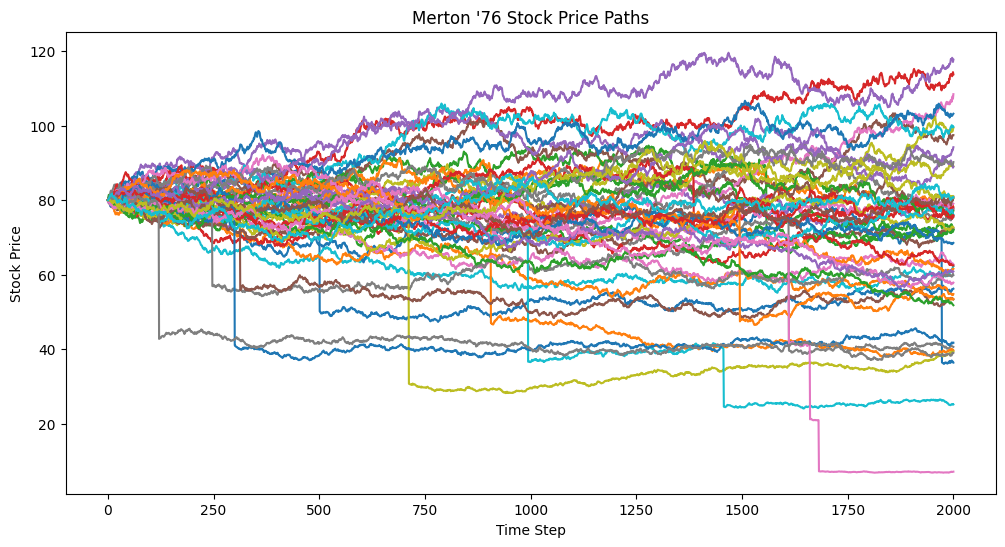

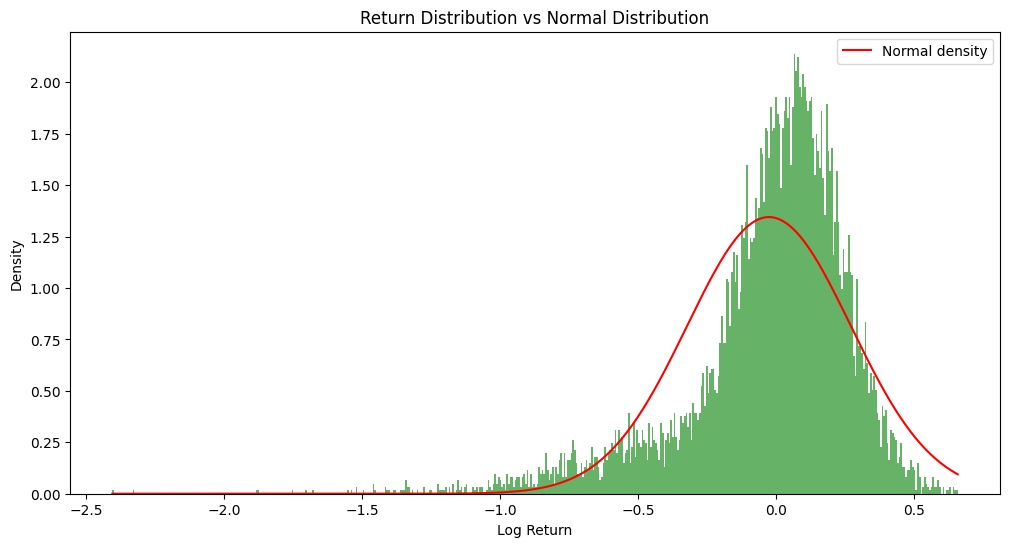

Q8 – λ=0.75 Return's Mean: -0.0269, Std Dev: 0.2967, Skewness: -1.4713, Kurtosis: 3.7074

=== Q8: Merton (lambda = 0.75) ===
ATM Call Option Price : 8.2089
ATM Put  Option Price : 7.0682


In [ ]:
mu = -0.5
delta = 0.22
lamb_075 = 0.75

SM_075 = merton_model.simulate_stock_paths(S0, T, r, sigma, lamb_075, mu, delta, I, M)
merton_model.plot_stock_paths(SM_075)

retSM_075 = merton_model.calculate_return_distribution(SM_075, S0)
merton_model.plot_return_distribution(retSM_075)
print(f"Q8 – λ=0.75 Return's Mean: {retSM_075.mean():.4f}, Std Dev: {retSM_075.std():.4f}, Skewness: {ss.skew(retSM_075):.4f}, Kurtosis: {ss.kurtosis(retSM_075):.4f}")

# Use shared-path pricer for parity-friendly prices
call_q8, put_q8 = merton_model.price_call_put_merton76(
    S0, K_ATM, T, r, sigma, lamb_075, mu, delta, I, M
)

print("\n=== Q8: Merton (lambda = 0.75) ===")
print(f"ATM Call Option Price : {call_q8:.2f}")
print(f"ATM Put  Option Price : {put_q8:.2f}")


## Q 9
#### Using the Merton Model, price an ATM European call and an ATM European put with jump intensity parameter equal to 0.25.



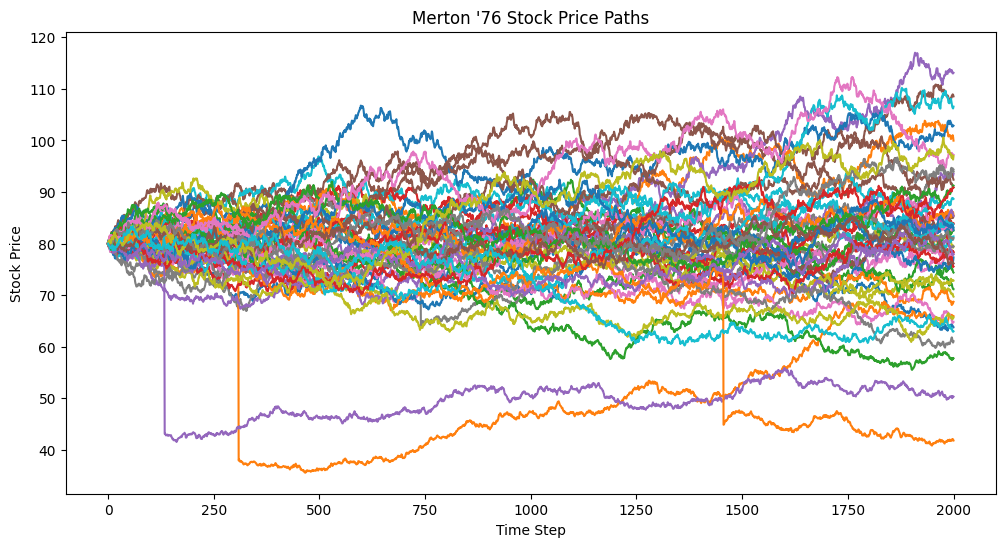

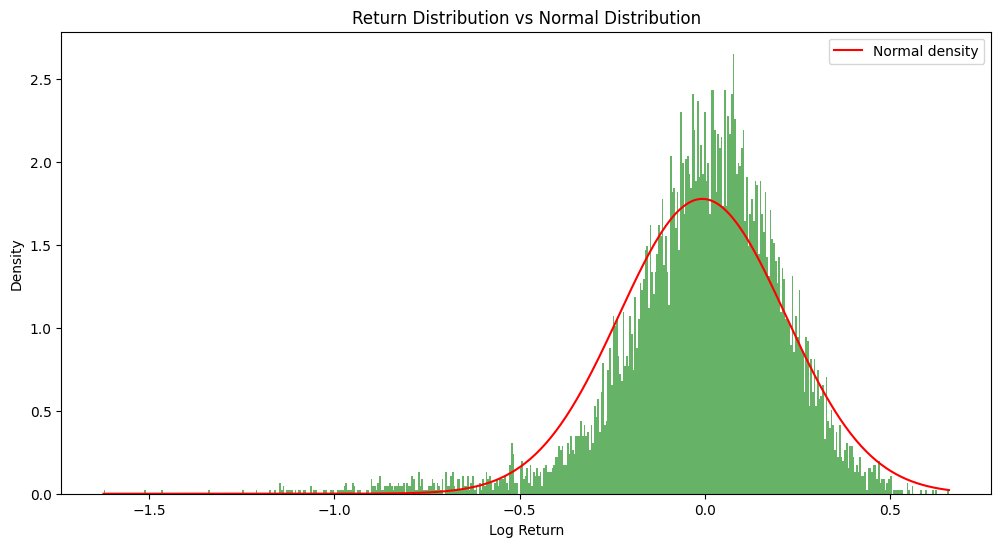


Q9 – λ=0.25 Return's Mean: -0.0072, Std Dev: 0.2245, Skewness: -1.1810, Kurtosis: 3.6441

=== Q9: Merton (lambda = 0.25) ===
ATM Call Option Price : 6.9925
ATM Put  Option Price : 5.8911


In [ ]:
lamb_025 = 0.25

SM_025 = merton_model.simulate_stock_paths(S0, T, r, sigma, lamb_025, mu, delta, I, M)
merton_model.plot_stock_paths(SM_025)

retSM_025 = merton_model.calculate_return_distribution(SM_025, S0)
merton_model.plot_return_distribution(retSM_025)
print(f"\nQ9 – λ=0.25 Return's Mean: {retSM_025.mean():.4f}, Std Dev: {retSM_025.std():.4f}, Skewness: {ss.skew(retSM_025):.4f}, Kurtosis: {ss.kurtosis(retSM_025):.4f}")


call_q9, put_q9 = merton_model.price_call_put_merton76(
    S0, K_ATM, T, r, sigma, lamb_025, mu, delta, I, M
)

print("\n=== Q9: Merton (lambda = 0.25) ===")
print(f"ATM Call Option Price : {call_q9:.4f}")
print(f"ATM Put  Option Price : {put_q9:.4f}")


## Q10 Calculating greeks

In [58]:
greeks = merton_model.calc_greeks(S0, K_ATM, T, r, sigma, lamb_075, mu, delta, I, M, option_type='call', h=0.5)

print(f"\n---Quantifying GREEKS at European Call option at lambda = {lamb_075} ---")
print(f"Delta : {greeks['Delta']:.6f}")
print(f"Gamma : {greeks['Gamma']:.6f}")


---Quantifying GREEKS at European Call option at lambda = 0.75 ---
Delta : 0.641885
Gamma : 0.026177


In [59]:
greeks = merton_model.calc_greeks(S0, K_ATM, T, r, sigma, lamb_075, mu, delta, I, M, option_type='put', h=0.5)

print(f"\n---Quantifying GREEKS at European Put option at lambda = {lamb_075} ---")
print(f"Delta : {greeks['Delta']:.6f}")
print(f"Gamma : {greeks['Gamma']:.6f}")


---Quantifying GREEKS at European Put option at lambda = 0.75 ---
Delta : -0.354110
Gamma : 0.026177


In [60]:
greeks = merton_model.calc_greeks(S0, K_ATM, T, r, sigma, lamb_025, mu, delta, I, M, option_type='call', h=0.5)

print(f"\n---Quantifying GREEKS at European Call option at lambda = {lamb_025} ---")
print(f"Delta : {greeks['Delta']:.6f}")
print(f"Gamma : {greeks['Gamma']:.6f}")


---Quantifying GREEKS at European Call option at lambda = 0.25 ---
Delta : 0.597396
Gamma : 0.028182


In [61]:
greeks = merton_model.calc_greeks(S0, K_ATM, T, r, sigma, lamb_025, mu, delta, I, M, option_type='put', h=0.5)

print(f"\n---Quantifying GREEKS at European Put option at lambda = {lamb_025} ---")
print(f"Delta : {greeks['Delta']:.6f}")
print(f"Gamma : {greeks['Gamma']:.6f}")


---Quantifying GREEKS at European Put option at lambda = 0.25 ---
Delta : -0.402178
Gamma : 0.028182


## Q11 – Put–call parity checker

In [17]:

class ModelValidator:
    def __init__(self, S0, r, T):
        self.S0 = S0
        self.r = r
        self.T = T

    def theoretical_parity(self, K):
        # C - P should equal S0 - K*e^{-rT}
        return self.S0 - K * np.exp(-self.r * self.T)

    def check_parity(self, K, call_price, put_price):
        lhs = call_price - put_price
        rhs = self.theoretical_parity(K)
        diff = lhs - rhs
        return lhs, rhs, diff

validator = ModelValidator(S0=S0, r=r, T=T)


### CHECKING PARITY FOR PRICES PUT CALLS FROM Q8 & Q9

In [18]:
rows = []


lhs, rhs, diff = validator.check_parity(K_ATM, call_q5, put_q5)
rows.append({
    "Question": "Q5",
    "Model": "Heston",
    "Scenario": "rho = -0.30",
    "K": K_ATM,
    "Call": call_q5,
    "Put": put_q5,
    "C - P": lhs,
    "S0 - K*exp(-rT)": rhs,
    "Difference": diff
})


lhs, rhs, diff = validator.check_parity(K_ATM, call_q6, put_q6)
rows.append({
    "Question": "Q6",
    "Model": "Heston",
    "Scenario": "rho = -0.70",
    "K": K_ATM,
    "Call": call_q6,
    "Put": put_q6,
    "C - P": lhs,
    "S0 - K*exp(-rT)": rhs,
    "Difference": diff
})


# Merton Q8
lhs, rhs, diff = validator.check_parity(K_ATM, call_q8, put_q8)
rows.append({
    "Question": "Q8",
    "Model": "Merton",
    "Scenario": "lambda = 0.75",
    "K": K_ATM,
    "Call": call_q8,

    "Put": put_q8,
    "C - P": lhs,
    "S0 - K*exp(-rT)": rhs,
    "Difference": diff
})

# Merton Q9
lhs, rhs, diff = validator.check_parity(K_ATM, call_q9, put_q9)
rows.append({
    "Question": "Q9",
    "Model": "Merton",
    "Scenario": "lambda = 0.25",
    "K": K_ATM,
    "Call": call_q9,
    "Put": put_q9,
    "C - P": lhs,
    "S0 - K*exp(-rT)": rhs,
    "Difference": diff
})

df_q11 = pd.DataFrame(rows)
df_q11


,Question,Model,Scenario,K,Call,Put,C - P,S0 - K*exp(-rT),Difference
0,Q5,Heston,rho = -0.30,80.0,3.474773,2.397726,1.077046,1.092472,-0.015426
1,Q6,Heston,rho = -0.70,80.0,3.495453,2.399823,1.095630,1.092472,0.003158
2,Q8,Merton,lambda = 0.75,80.0,8.275902,7.232297,1.043605,1.092472,-0.048867
3,Q9,Merton,lambda = 0.25,80.0,6.860613,5.767564,1.093049,1.092472,0.000577


## Q12 – 7 strikes with moneyness for Heston & Merton

In [19]:
moneyness_values = np.array([0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15])
strikes = S0 / moneyness_values  # K = S0 / m


print("Moneyness and Strikes:")
for m, k in zip(moneyness_values, strikes):
    print(f"m = {m:.2f},  K ≈ {k:.4f}")


Moneyness and Strikes:
m = 0.85,  K ≈ 94.1176
m = 0.90,  K ≈ 88.8889
m = 0.95,  K ≈ 84.2105
m = 1.00,  K ≈ 80.0000
m = 1.05,  K ≈ 76.1905
m = 1.10,  K ≈ 72.7273
m = 1.15,  K ≈ 69.5652


In [20]:


rho_q12 = -0.70

# 1) Simulating ONE set of Heston paths for this rho
rand_q12 = random_number_gen(M, I)

cov_q12 = np.array([[1.0, rho_q12],
                    [rho_q12, 1.0]])
cho_q12 = np.linalg.cholesky(cov_q12)

V_q12 = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand_q12, cho_q12)
S_q12 = Heston_paths(S0, r, V_q12, T, M, I, rand_q12, cho_q12)

ST_q12 = S_q12[-1, :]
disc = np.exp(-r * T)

heston_call_prices = []
heston_put_prices = []

# 2) Price all strikes off the same terminal prices
for K in strikes:
    call_h = disc * np.mean(np.maximum(ST_q12 - K, 0.0))
    put_h  = disc * np.mean(np.maximum(K - ST_q12, 0.0))
    heston_call_prices.append(call_h)
    heston_put_prices.append(put_h)



In [21]:
# Merton prices for 7 strikes (lambda = 0.75)

merton_call_prices = []
merton_put_prices = []

for K in strikes:
    c_price = merton_model.price_option_merton76(S0, K, T, r, sigma, lamb_075, mu, delta, I, M, option_type='call')
    p_price = merton_model.price_option_merton76(S0, K, T, r, sigma, lamb_075, mu, delta, I, M, option_type='put')
    merton_call_prices.append(c_price)
    merton_put_prices.append(p_price)


In [23]:
df_q12 = pd.DataFrame({
    "Moneyness (S0/K)": moneyness_values,
    "Strike K": strikes,
    "Heston Call": heston_call_prices,
    "Heston Put": heston_put_prices,
    "Merton Call (λ=0.75)": merton_call_prices,
    "Merton Put  (λ=0.75)": merton_put_prices
})

df_q12


,Moneyness (S0/K),Strike K,Heston Call,Heston Put,Merton Call (λ=0.75),Merton Put (λ=0.75)
0,0.85,94.117647,0.044956,12.906453,2.793767,15.659658
1,0.90,88.888889,0.376496,8.080639,4.305201,12.033918
2,0.95,84.210526,1.481701,4.571369,6.176104,9.384269
3,1.00,80.000000,3.481479,2.418119,8.315273,7.198885
4,1.05,76.190476,6.054430,1.233568,10.554930,5.711196
5,1.10,72.727273,8.855697,0.618925,12.850514,4.559387
6,1.15,69.565217,11.663043,0.307396,15.088351,3.781139


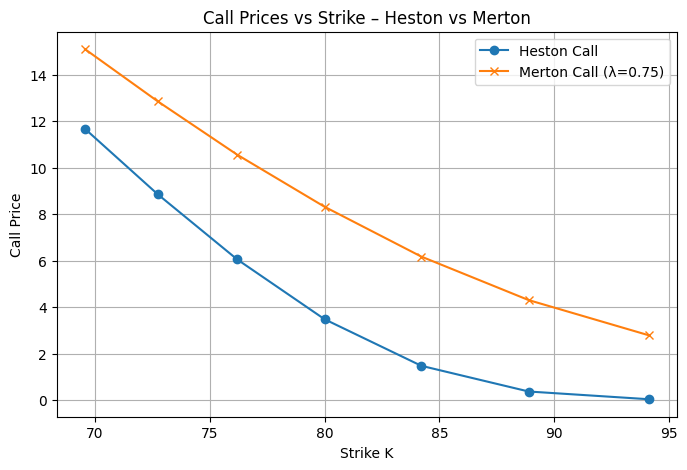

In [24]:
# === Call Prices vs Strike: Heston vs Merton (λ = 0.75) ===

plt.figure(figsize=(8,5))
plt.plot(df_q12["Strike K"], df_q12["Heston Call"], marker="o", label="Heston Call")
plt.plot(df_q12["Strike K"], df_q12["Merton Call (λ=0.75)"], marker="x", label="Merton Call (λ=0.75)")
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("Call Prices vs Strike – Heston vs Merton")
plt.grid(True)
plt.legend()
plt.show()


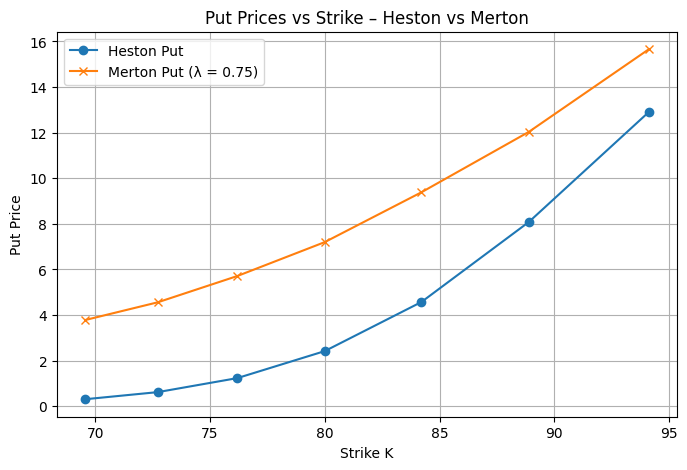

In [25]:
# === Put Prices vs Strike: Heston vs Merton (λ = 0.75) ===

plt.figure(figsize=(8, 5))
plt.plot(strikes, heston_put_prices, marker='o', label='Heston Put')
plt.plot(strikes, merton_put_prices, marker='x', label='Merton Put (λ = 0.75)')

plt.title("Put Prices vs Strike – Heston vs Merton")
plt.xlabel("Strike K")
plt.ylabel("Put Price")
plt.grid(True)
plt.legend()
plt.show()


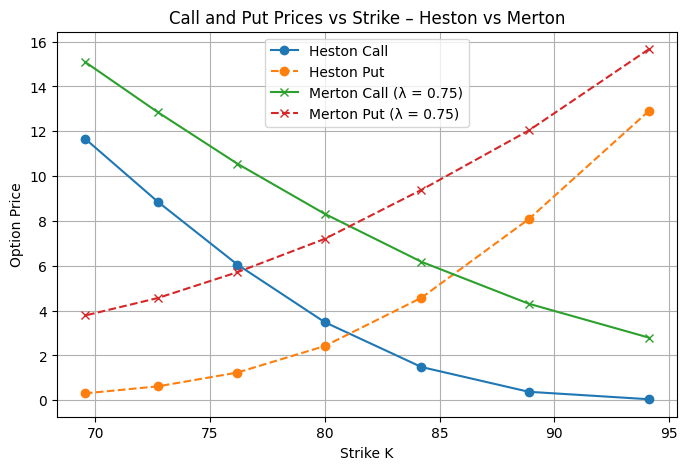

In [26]:
plt.figure(figsize=(8, 5))

# Heston
plt.plot(strikes, heston_call_prices, marker='o', linestyle='-',  label='Heston Call')
plt.plot(strikes, heston_put_prices,  marker='o', linestyle='--', label='Heston Put')

# Merton
plt.plot(strikes, merton_call_prices, marker='x', linestyle='-',  label='Merton Call (λ = 0.75)')
plt.plot(strikes, merton_put_prices,  marker='x', linestyle='--', label='Merton Put (λ = 0.75)')

plt.title("Call and Put Prices vs Strike – Heston vs Merton")
plt.xlabel("Strike K")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()


## Q13
Finding American Call and ameican Put prices based off Q5 and Q6

In [27]:
import numpy as np

def american_call_heston_lsm(
    S0=80.0, K=80.0, r=0.055, T=3/12,
    v0=0.032, kappa=1.85, theta=0.045, sigma_v=0.35, rho=-0.30,
    n_steps=120, n_paths=150_000, seed=2026, basis="poly2_sv"
):
    """
    American CALL under Heston via Longstaff–Schwartz (LSM).

    basis:
        "poly2_s"  -> [1, S, S^2]
        "poly2_sv" -> [1, S, S^2, v, v*S]

    Returns (price, standard_error).
    """

    rng = np.random.default_rng(seed)
    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)
    disc = np.exp(-r * dt)

    # --- simulate paths (full-truncation Euler; correlated shocks)
    Zs = rng.standard_normal((n_steps, n_paths))
    Zv = rng.standard_normal((n_steps, n_paths))

    S = np.full((n_steps + 1, n_paths), S0, dtype=np.float64)
    v = np.full((n_steps + 1, n_paths), v0, dtype=np.float64)

    for t in range(1, n_steps + 1):
        w2 = rho * Zs[t - 1] + np.sqrt(1 - rho**2) * Zv[t - 1]

        vpos = np.maximum(v[t - 1], 0.0)
        v[t] = v[t - 1] + kappa * (theta - vpos) * dt + sigma_v * np.sqrt(vpos) * sqrt_dt * w2
        v[t] = np.maximum(v[t], 0.0)

        S[t] = S[t - 1] * np.exp((r - 0.5 * vpos) * dt + np.sqrt(vpos) * sqrt_dt * Zs[t - 1])

    payoff = np.maximum(S - K, 0.0)

    # --- LSM backward induction
    CF = payoff[-1].copy()  # final payoffs

    for t in range(n_steps - 1, 0, -1):

        # discount cashflows
        CF *= disc

        itm = payoff[t] > 0  # in-the-money
        if not np.any(itm):
            continue

        X = S[t, itm]

        # choose basis
        if basis == "poly2_s":
            A = np.stack([np.ones_like(X), X, X*X], axis=1)
        else:  # poly2_sv
            Vt = v[t, itm]
            A = np.stack([np.ones_like(X), X, X*X, Vt, Vt * X], axis=1)

        Y = CF[itm]  # continuation values (discounted)

        # regression
        beta, *_ = np.linalg.lstsq(A, Y, rcond=None)
        cont = A @ beta

        exercise = payoff[t, itm] > cont
        CF[itm] = np.where(exercise, payoff[t, itm], Y)

    # price at t=0
    price = CF.mean()
    se = CF.std(ddof=1) / np.sqrt(n_paths)

    return float(price), float(se)


if __name__ == "__main__":
    price, se = american_call_heston_lsm(rho=-0.30)
    print(f"American Call Price under Heston = {price:.3f}, SE = {se:.4f}")


American Call Price under Heston = 3.439, SE = 0.0113


## Q14

Using Heston model data from Question 6 to price a European up-and-in call option (CUI) with a barrier level of 95 and a strike price of 95

In [32]:

def price_vanilla_call_from_paths(S_paths, K, r, T):
    """
    Price a standard European call using given simulated paths.
    S_paths: array shape (M+1, I)
    """
    ST = S_paths[-1, :]
    payoff = np.maximum(ST - K, 0.0)
    return np.exp(-r * T) * np.mean(payoff)


def price_up_and_in_call_from_paths(S_paths, K, H_barrier, r, T):
    """
    Price a European up-and-in call:
    - barrier H (up)
    - strike K
    - payoff = max(S_T - K, 0) if the path ever hits H before maturity, else 0.
    """
    # terminal prices
    ST = S_paths[-1, :]

    # for each path, check if barrier was ever reached at any time step
    # S_paths shape: (M+1, I)
    hit_barrier = (S_paths >= H_barrier).any(axis=0)  # boolean array length I

    # payoff only for paths that hit the barrier
    vanilla_payoff = np.maximum(ST - K, 0.0)
    payoff = np.where(hit_barrier, vanilla_payoff, 0.0)

    return np.exp(-r * T) * np.mean(payoff)


In [33]:
# Parameters for Q14
H_barrier =95.0   # barrier level
K_barrier = 95.0   # strike

# Using the Heston Q6 paths (rho = -0.70)
# S_q6 was created in the Q6 cell

# Price vanilla call with K = 95 using same Heston Q6 paths
vanilla_call_95 = price_vanilla_call_from_paths(S_q6, K_barrier, r, T)

# Price up-and-in call using same paths and barrier
cui_call_95 = price_up_and_in_call_from_paths(S_q6, K_barrier, H_barrier, r, T)

print("=== Q14: Up-and-In Call vs Vanilla Call under Heston (rho = -0.70) ===")
print(f"Vanilla European Call (K=95): {vanilla_call_95:.4f}")
print(f"Up-and-In Call (K=95, H=95): {cui_call_95:.4f}")
print(f"Difference (Vanilla - Up-and-In): {vanilla_call_95 - cui_call_95:.4f}")
print(f"Ratio (Up-and-In / Vanilla): {cui_call_95 / vanilla_call_95:.4f}")


=== Q14: Up-and-In Call vs Vanilla Call under Heston (rho = -0.70) ===
Vanilla European Call (K=95): 0.0311
Up-and-In Call (K=95, H=95): 0.0311
Difference (Vanilla - Up-and-In): 0.0000
Ratio (Up-and-In / Vanilla): 1.0000


In [34]:
def price_vanilla_call_from_paths(S_paths, K, r, T):
    ST = S_paths[-1, :]
    payoff = np.maximum(ST - K, 0.0)
    return np.exp(-r * T) * np.mean(payoff)

def price_up_and_in_call_from_paths(S_paths, K, H_barrier, r, T):
    ST = S_paths[-1, :]
    hit_barrier = (S_paths >= H_barrier).any(axis=0)
    vanilla_payoff = np.maximum(ST - K, 0.0)
    payoff = np.where(hit_barrier, vanilla_payoff, 0.0)
    return np.exp(-r * T) * np.mean(payoff)


In [35]:
# Extra analysis: moneyness 1 (K = S0) and different barrier levels

# Use same Heston parameters as Q6 (rho = -0.70)
rho_barrier = -0.70

# (We already have v0, kappa_v, theta_v, sigma_v, S0, r, T, M, I defined globally)

# Re-simulate Heston paths for this analysis
rand_barrier = random_number_gen(M, I)

cov_barrier = np.array([[1.0, rho_barrier],
                        [rho_barrier, 1.0]])
cho_barrier = np.linalg.cholesky(cov_barrier)

V_barrier = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand_barrier, cho_barrier)
S_barrier = Heston_paths(S0, r, V_barrier, T, M, I, rand_barrier, cho_barrier)

K_m1 = 95

# Range of barriers (some below, equal to, and above K)
barrier_levels = np.array([ 85, 90, 95, 100, 105, 110, 115])

# Vanilla call price with K = S0
vanilla_m1 = price_vanilla_call_from_paths(S_barrier, K_m1, r, T)

up_in_prices = []
diffs = []
ratios = []

for H in barrier_levels:
    c_ui = price_up_and_in_call_from_paths(S_barrier, K_m1, H, r, T)
    up_in_prices.append(c_ui)
    diffs.append(vanilla_m1 - c_ui)
    ratios.append(c_ui / vanilla_m1 if vanilla_m1 > 0 else np.nan)

df_barrier_sensitivity = pd.DataFrame({
    "Barrier H": barrier_levels,
    "Strike K": K_m1,
    "Vanilla Call (K=S0)": vanilla_m1,
    "Up-and-In Call": up_in_prices,
    "Difference (Vanilla - UI)": diffs,
    "UI / Vanilla": ratios
})

df_barrier_sensitivity


,Barrier H,Strike K,Vanilla Call (K=S0),Up-and-In Call,Difference (Vanilla - UI),UI / Vanilla
0,85,95,0.029538,0.029538,0.000000,1.000000
1,90,95,0.029538,0.029538,0.000000,1.000000
2,95,95,0.029538,0.029538,0.000000,1.000000
3,100,95,0.029538,0.010389,0.019148,0.351735
4,105,95,0.029538,0.001327,0.028211,0.044928
5,110,95,0.029538,0.000000,0.029538,0.000000
6,115,95,0.029538,0.000000,0.029538,0.000000


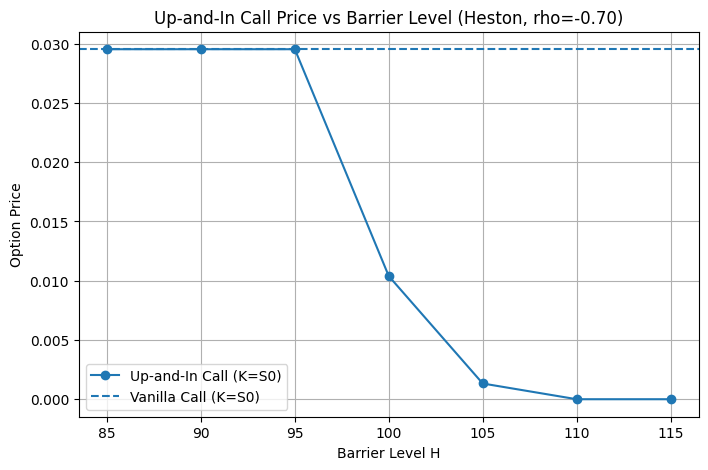

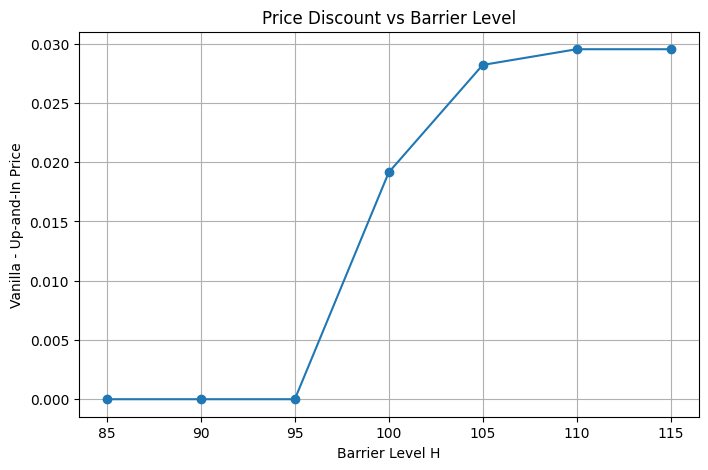

In [36]:
# Plot Up-and-In price vs Barrier
plt.figure(figsize=(8, 5))
plt.plot(df_barrier_sensitivity["Barrier H"], df_barrier_sensitivity["Up-and-In Call"],
         marker="o", label="Up-and-In Call (K=S0)")
plt.axhline(y=vanilla_m1, linestyle="--", label="Vanilla Call (K=S0)")
plt.xlabel("Barrier Level H")
plt.ylabel("Option Price")
plt.title("Up-and-In Call Price vs Barrier Level (Heston, rho=-0.70)")
plt.grid(True)
plt.legend()
plt.show()

# Plot difference (how much cheaper than vanilla) vs Barrier
plt.figure(figsize=(8, 5))
plt.plot(df_barrier_sensitivity["Barrier H"], df_barrier_sensitivity["Difference (Vanilla - UI)"],
         marker="o")
plt.xlabel("Barrier Level H")
plt.ylabel("Vanilla - Up-and-In Price")
plt.title("Price Discount vs Barrier Level")
plt.grid(True)
plt.show()


## Q15

Using Merton model data from Question 8 with a price a European down-and-in put option (PDI) with a barrier level of $65 and a strike price of $65 as well.

In [51]:
def price_down_and_in_put(merton_model, S0, K, B, T, r, sigma, lamb, mu, delta, I, M):
    SM = merton_model.simulate_stock_paths(S0, T, r, sigma, lamb, mu, delta, I, M)  # shape (M+1, I)
    ST = SM[-1, :]
    knocked_in = np.min(SM, axis=0) <= B
    payoffs = np.where(knocked_in, np.maximum(K - ST, 0.0), 0.0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price, knocked_in, ST

def compare_pdi_vs_vanilla(merton_model, S0, K, B, T, r, sigma, lamb, mu, delta, I, M):
    pdi_price, knocked_in, ST = price_down_and_in_put(merton_model, S0, K, B, T, r, sigma, lamb, mu, delta, I, M)
    vanilla_put = merton_model.price_option_merton76(S0, K, T, r, sigma, lamb, mu, delta, I, M, option_type='put')
    prob_knock = np.mean(knocked_in)
    avg_pay_if_knocked = np.mean(np.maximum(K - ST, 0.0)[knocked_in]) if np.any(knocked_in) else 0.0

    print(f"--- Results for lambda = {lamb:.2f} ---")
    print(f"Down-and-In Put price (Barrier B={B}, Strike K={K}): {pdi_price:.6f}")
    print(f"Vanilla European Put price:                          {vanilla_put:.6f}")
    print(f"Percentage of simulated paths that hit barrier:      {prob_knock*100:.2f}%")
    if np.any(knocked_in):
        print(f"Average conditional payoff (given knock-in):     {avg_pay_if_knocked:.6f}")
    print("Note: Usually PDI <= Vanilla Put because PDI pays only if barrier hit.")
    return {'lambda': lamb, 'pdi_price': pdi_price, 'vanilla_put': vanilla_put,
            'prob_knock': prob_knock, 'avg_pay_if_knocked': avg_pay_if_knocked}

In [52]:
def run_all(S0=80.0, K=80.0, T=1/4, r=0.055, sigma=0.35, mu=-0.5, delta=0.22,
            lambdas=[0.75, 0.25], I=10000, M=2000, barrier=65.0, greek_h=0.005):
    results = []
    print(f"Barrier Down-and-In put option (PDI) with barrier ${barrier} and strike price ${barrier}\n")
    for lamb in lambdas:
        pdi_price, knocked_in, ST = price_down_and_in_put(merton_model, S0, barrier, barrier, T, r, sigma, lamb, mu, delta, I, M)
        vanilla_put_barrierstrike = merton_model.price_option_merton76(S0, barrier, T, r, sigma, lamb, mu, delta, I, M, option_type='put')
        prob_knock = np.mean(knocked_in)
        avg_pay_if_knocked = np.mean(np.maximum(barrier - ST, 0.0)[knocked_in]) if np.any(knocked_in) else 0.0

        print(f"Down-and-In Put under lambda={lamb:.2f}: {pdi_price:.6f}")
        print(f"Vanilla Put with strike K={barrier}: {vanilla_put_barrierstrike:.6f}")
        print(f"Percentage of paths that hit the barrier: {prob_knock*100:.2f}%")
        print(f"Avg payoff if knocked-in: {avg_pay_if_knocked:.6f}")
        print("-" * 60)
        
        results.append({'lambda': lamb, 'pdi_price': pdi_price,'vanilla_put_strike_barrier': vanilla_put_barrierstrike,'prob_knock': prob_knock,'avg_pay_if_knocked': avg_pay_if_knocked})

In [53]:
if __name__ == "__main__":
    # Use the parameters you specified earlier
    S0 = 80.0
    T = 1/4
    r = 0.055
    sigma = 0.35
    mu = -0.5
    delta = 0.22
    I = 10000    # number of simulations
    M = 2000     # number of time steps
    barrier = 65.0

    # Note: K is set equal to S0 for ATM call/put; barrier strike comparison uses K=barrier too
    results = run_all(S0=S0, K=S0, T=T, r=r, sigma=sigma, mu=mu, delta=delta,
                      lambdas=[0.75, 0.25], I=I, M=M, barrier=barrier, greek_h=0.005)

    # results is a list of dictionaries with the values printed above

Barrier Down-and-In put option (PDI) with barrier $65.0 and strike price $65.0

Down-and-In Put under lambda=0.75: 2.801535
Vanilla Put with strike K=65.0: 2.715882
Percentage of paths that hit the barrier: 27.29%
Avg payoff if knocked-in: 10.407922
------------------------------------------------------------
Down-and-In Put under lambda=0.25: 1.424718
Vanilla Put with strike K=65.0: 1.336904
Percentage of paths that hit the barrier: 24.60%
Avg payoff if knocked-in: 5.871722
------------------------------------------------------------
